In [490]:
import gseapy as gp
import pandas as pd

import h5py
import numpy as np
import pandas as pd
from collections import defaultdict
import phate
import scanpy as sc
import umap

from anndata import AnnData

import plotly.express as px
import plotly.graph_objects as go

# Build GSEA table for all tumor-cluster pairs

In [169]:
threshold = 0.05
TUMOR_IDS = [1,2,3,4,5,6,7,8]

In [188]:
gsea_table = pd.DataFrame()

for tumor in TUMOR_IDS:
    de_genes_tumor_df = pd.read_csv("data/interim/MK_genes_TUMOR{}.csv".format(tumor))
    de_genes_by_cluster = de_genes_tumor_df.groupby("cluster")["gene"].apply(lambda x: "|".join(x.unique()))
    
    for cluster in de_genes_by_cluster.index:
        gene_list = de_genes_by_cluster[cluster].split("|")
        tumor_cluster = id_tumor[tumor] + "_" + str(cluster)

        enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=['GO_Biological_Process_2018',
                                'GO_Cellular_Component_2018',
                                'GO_Molecular_Function_2018'],
                     no_plot=True,
                     cutoff=0.05 # test dataset, use lower value from range(0,1)
                    )
        if threshold:
            enr.results = enr.results[enr.results["Adjusted P-value"] < threshold]
        enr_results = enr.results.set_index("Term")
        
        for geneset in enr_results.index:
            gsea_table.loc[geneset, tumor_cluster] = enr_results.loc[geneset, "Adjusted P-value"]

In [197]:
tumor_cluster_gsea = gsea_table.T
tumor_cluster_gsea.index = pd.MultiIndex.from_tuples(tumor_cluster_gsea.index.str.split("_", expand=True),
                                                    names=["tumor", "cluster"])
tumor_cluster_gsea

cellular response to copper ion (GO:0071280)  \
tumor cluster                                                 
PJ016 0                                            0.000008   
      1                                                 NaN   
      2                                                 NaN   
      3                                                 NaN   
      4                                                 NaN   
...                                                     ...   
PJ048 5                                                 NaN   
      6                                            0.008055   
      7                                                 NaN   
      8                                                 NaN   
      10                                                NaN   

               response to copper ion (GO:0046688)  \
tumor cluster                                        
PJ016 0                                   0.000010   
      1                                        NaN   
      2                                        NaN   
      3                                        NaN   
      4                                        NaN   
...                                            ...   
PJ048 5                                        NaN   
      6                                   0.011066   
      7                                        NaN   
      8                                        NaN   
      10                                       NaN   

               cellular response to zinc ion (GO:0071294)  \
tumor cluster                                               
PJ016 0                                          0.000222   
      1                                               NaN   
      2                                               NaN   
      3                                               NaN   
      4                                               NaN   
...                                                   ...   
PJ048 5                                               NaN   
      6                                          0.007067   
      7                                               NaN   
      8                                               NaN   
      10                                              NaN   

               cellular response to cadmium ion (GO:0071276)  \
tumor cluster                                                  
PJ016 0                                             0.001000   
      1                                                  NaN   
      2                                                  NaN   
      3                                                  NaN   
      4                                                  NaN   
...                                                      ...   
PJ048 5                                                  NaN   
      6                                             0.015403   
      7                                                  NaN   
      8                                                  NaN   
      10                                                 NaN   

               cellular zinc ion homeostasis (GO:0006882)  \
tumor cluster                                               
PJ016 0                                          0.001056   
      1                                               NaN   
      2                                               NaN   
      3                                               NaN   
      4                                               NaN   
...                                                   ...   
PJ048 5                                               NaN   
      6                                          0.016894   
      7                                               NaN   
      8                                               NaN   
      10                                              NaN   

               response to cadmium ion (GO:0046686)  \
tumor cluster   

In [377]:
def heatmap(table, autosize=True, width=800, height=1000):
    if type(table.columns) == pd.MultiIndex:
        columns = table.columns.to_series().apply(lambda x: '{0}-{1}'.format(*x))
    else:
        columns = table.columns
    fig = go.Figure(data=go.Heatmap(
                    z=table,
                    x=columns,
                    y=table.index,
                    hoverongaps = False,))
    fig.update_layout(
        title="Gene set enrichment of DE genes by tumor_cluster",
        autosize=True,
        width=width,
        height=height,
    )
    fig.show()

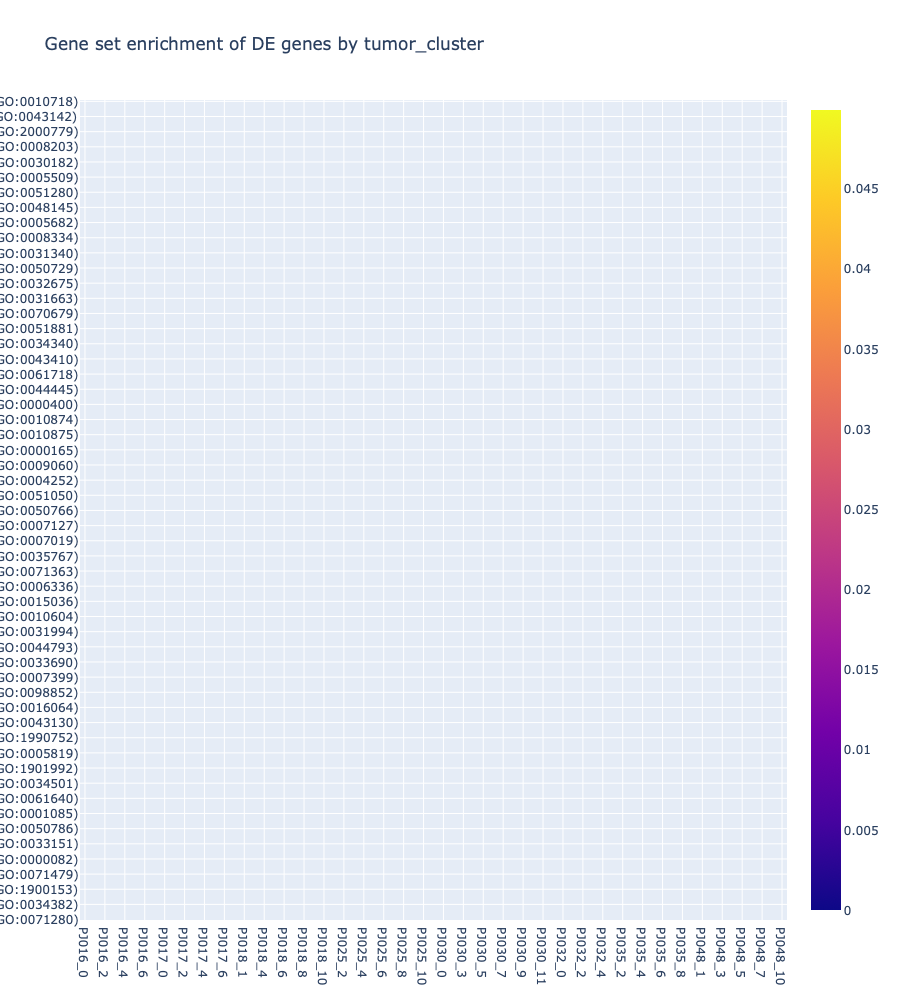

In [191]:
heatmap(gsea_table)

# Build expression table for tumor_cell by biomarker

In [256]:
DATA_F = 'data/GSE103224.h5'
BIOMARKER_F = 'data/glioma_survival_associated_genes_Fatai.csv'

In [4]:
with h5py.File(DATA_F, 'r') as f:
    CELLS = [
        str(x)[2:-1]
        for x in f['cell'][:]
    ]
    TUMORS = [
        str(x)[2:-1]
        for x in f['tumor'][:]
    ]
    GENE_IDS = [
        str(x)[2:-1]
        for x in f['gene_id'][:]
    ]
    GENE_NAMES = [
        str(x)[2:-1]
        for x in f['gene_name'][:]
    ]
    
# Map each cell to its index in the data matrix
CELL_TO_INDEX = {
    cell: index
    for index, cell in enumerate(CELLS)
}

# Map each tumor to its indices in the data matrix
TUMOR_TO_INDICES = defaultdict(lambda: [])
for index, tumor in enumerate(TUMORS):
    TUMOR_TO_INDICES[tumor].append(index)
TUMOR_TO_INDICES = dict(TUMOR_TO_INDICES)

def counts_matrix_for_tumor(tumor):
    indices = TUMOR_TO_INDICES[tumor]
    with h5py.File(DATA_F, 'r') as f:
        counts = f['count'][indices]
    cells = list(np.array(CELLS)[indices])
    return counts, cells

In [5]:
TUMORS = np.unique(TUMORS)
tumor_id = {tumor:tumor_id+1 for tumor_id,tumor in enumerate(TUMORS)}
id_tumor = {tumor_id+1:tumor for tumor_id,tumor in enumerate(TUMORS)}

In [37]:
tumor_ans = {}
for tumor in TUMORS:
    print(tumor)
    counts, cells = counts_matrix_for_tumor(tumor)
    ad = AnnData(
            X=counts, 
            obs=pd.DataFrame(data=cells, columns=['cell']),
            var=pd.DataFrame(
                index=GENE_NAMES, 
                data=GENE_NAMES, 
                columns=['gene_name']
            )
        )
    sc.pp.normalize_total(ad, target_sum=1e6)
    sc.pp.log1p(ad)
    ad.X = pd.DataFrame(ad.X, index=cells, columns=GENE_NAMES)
    tumor_ans[tumor] = ad

PJ016


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ017


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ018


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ025


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ030


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ032


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ035


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PJ048


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [24]:
tumor_ans["PJ016"].X.index.str.split("_", expand=True).get_level_values(1).astype(int)+1

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085],
           dtype='int64', length=3085)

In [41]:
for tumor in TUMORS:
    tumor_ans[tumor].X.index = pd.MultiIndex.from_tuples(tumor_ans[tumor].X.index.str.split("_", expand=True), 
                                             names=["tumor", "cell"])

In [76]:
all_tumor_df = pd.concat([tumor_ans[tumor].X for tumor in TUMORS])

SLC7A10  RAX  AC007228.11  AC092667.2  RP11-131K5.1  RNA5SP235  \
tumor cell                                                                   
PJ016 0         0.0  0.0          0.0         0.0           0.0        0.0   
      1         0.0  0.0          0.0         0.0           0.0        0.0   
      2         0.0  0.0          0.0         0.0           0.0        0.0   
      3         0.0  0.0          0.0         0.0           0.0        0.0   
      4         0.0  0.0          0.0         0.0           0.0        0.0   
...             ...  ...          ...         ...           ...        ...   
PJ048 3079      0.0  0.0          0.0         0.0           0.0        0.0   
      3080      0.0  0.0          0.0         0.0           0.0        0.0   
      3081      0.0  0.0          0.0         0.0           0.0        0.0   
      3082      0.0  0.0          0.0         0.0           0.0        0.0   
      3083      0.0  0.0          0.0         0.0           0.0        0.0   

              ZNF367  AC080003.1  SULT1B1    TRIM63  ...  MAGEB17  FBN2  \
tumor cell                                           ...                  
PJ016 0     0.000000         0.0      0.0  0.000000  ...      0.0   0.0   
      1     5.595795         0.0      0.0  0.000000  ...      0.0   0.0   
      2     0.000000         0.0      0.0  6.213578  ...      0.0   0.0   
      3     3.681268         0.0      0.0  0.000000  ...      0.0   0.0   
      4     0.000000         0.0      0.0  6.918252  ...      0.0   0.0   
...              ...         ...      ...       ...  ...      ...   ...   
PJ048 3079  0.000000         0.0      0.0  0.000000  ...      0.0   0.0   
      3080  0.000000         0.0      0.0  0.000000  ...      0.0   0.0   
      3081  0.000000         0.0      0.0  0.000000  ...      0.0   0.0   
      3082  0.000000         0.0      0.0  0.000000  ...      0.0   0.0   
      3083  0.000000         0.0      0.0  0.000000  ...      0.0   0.0   

            TRIM40  KIAA1919  RP4-569M23.4  RP11-330H6.6  RN7SKP167  \
tumor cell                                                            
PJ016 0        0.0  0.000000           0.0           0.0        0.0   
      1        0.0  3.671921           0.0           0.0        0.0   
      2        0.0  0.000000           0.0           0.0        0.0   
      3        0.0  3.681268           0.0           0.0        0.0   
      4        0.0  0.000000           0.0           0.0        0.0   
...            ...       ...           ...           ...        ...   
PJ048 3079     0.0  0.000000           0.0           0.0        0.0   
      3080     0.0  0.000000           0.0           0.0        0.0   
      3081     0.0  0.000000           0.0           0.0        0.0   
      3082     0.0  0.000000           0.0           0.0        0.0   
      3083     0.0  0.000000           0.0           0.0        0.0   

            RN7SL180P  OR5H5P     THAP6  
tumor cell                               
PJ016 0           0.0     0.0  3.668752  
      1           0.0     0.0  0.000000  
      2           0.0     0.0  0.000000  
      3           0.0     0.0  0.000000  
      4           0.0     0.0  0.000000  
...               ...     ...       ...  
PJ048 3079        0.0     0.0  0.000000  
      3080        0.0     0.0  0.000000  
      3081        0.0     0.0  0.000000  
      3082        0.0     0.0  0.000000  
      3083        0.0     0.0  0.000000  

[23793 rows x 60725 columns]

# Build tumor_cell_name to cluster_id table

In [232]:
tumor_cell_cluster = pd.DataFrame(columns=["tumor", "cell", "cluster"])

for tumor in TUMOR_IDS:
    cell_cluster = pd.read_csv("data/interim/T{}_META.csv".format(tumor))

    cell_cluster.rename(columns={"Unnamed: 0": "cell", "RNA_snn_res.0.8":"cluster"}, 
                        inplace=True)
    cell_cluster["cell"] = cell_cluster["cell"].str.split("_", expand=True)[1].astype(int)-1
    cell_cluster["cell"] = cell_cluster["cell"].astype(str)
    cell_cluster["tumor"] = id_tumor[tumor]

    tumor_cell_cluster = tumor_cell_cluster.append(cell_cluster[["tumor", "cell", "cluster"]])

tumor_cell_cluster["cluster"] = tumor_cell_cluster["cluster"].astype(str)
tumor_cell_cluster.set_index(["tumor", "cell"], inplace=True)

# Filter clusters with non-negative biomarker expressions

In [257]:
quantile_threshold = 0.75

In [258]:
biomarkers_df = pd.read_table(BIOMARKER_F, )
biomarkers = pd.Index(GENE_NAMES) & biomarkers_df["Gene"].unique()

In [259]:
all_tumor_cell_biomarkers = all_tumor_df[biomarkers]

In [260]:
cluster_exp = pd.merge(all_tumor_cell_biomarkers, tumor_cell_cluster, on=["tumor", "cell"])\
    .reset_index().set_index(["tumor", "cell", "cluster"])

In [362]:
cluster_exp_quantile = cluster_exp.groupby(["tumor", "cluster"])[biomarkers].quantile(quantile_threshold)
cluster_exp_quantile

TIMP1     CASP3  PLA2G5      CDC6     TIMP4  INHBB  HOMER1  \
tumor cluster                                                                  
PJ016 0        0.000000  0.000000     0.0  0.000000  5.238887    0.0     0.0   
      1        0.000000  0.000000     0.0  0.000000  5.067392    0.0     0.0   
      2        0.000000  4.435354     0.0  4.780128  0.000000    0.0     0.0   
      3        0.000000  4.118914     0.0  0.000000  5.032017    0.0     0.0   
      4        0.000000  0.000000     0.0  0.000000  0.000000    0.0     0.0   
...                 ...       ...     ...       ...       ...    ...     ...   
PJ048 5        0.000000  0.000000     0.0  0.000000  0.000000    0.0     0.0   
      6        6.265176  0.000000     0.0  0.000000  0.000000    0.0     0.0   
      7        0.000000  0.000000     0.0  0.000000  0.000000    0.0     0.0   
      8        0.000000  0.000000     0.0  0.000000  0.000000    0.0     0.0   
      9        0.000000  0.000000     0.0  0.000000  0.000000    0.0     0.0   

                 PDLIM3  RPRM  DKK1  ...     G6PC3   GADD45G  FBXO17  PTPRN  \
tumor cluster                        ...                                      
PJ016 0        0.000000   0.0   0.0  ...  4.613292  6.377615     0.0    0.0   
      1        4.531242   0.0   0.0  ...  4.679340  5.423159     0.0    0.0   
      2        5.107424   0.0   0.0  ...  0.000000  6.740180     0.0    0.0   
      3        4.678723   0.0   0.0  ...  4.997902  5.933023     0.0    0.0   
      4        0.000000   0.0   0.0  ...  0.000000  7.887485     0.0    0.0   
...                 ...   ...   ...  ...       ...       ...     ...    ...   
PJ048 5        0.000000   0.0   0.0  ...  0.000000  0.000000     0.0    0.0   
      6        0.000000   0.0   0.0  ...  0.000000  0.000000     0.0    0.0   
      7        0.000000   0.0   0.0  ...  0.000000  0.000000     0.0    0.0   
      8        0.000000   0.0   0.0  ...  0.000000  5.440972     0.0    0.0   
      9        0.000000   0.0   0.0  ...  0.000000  5.840432     0.0    0.0   

                    WAC  STAG3L4  EFEMP2  PPARGC1A      EGFR      MT1E  
tumor cluster                                                           
PJ016 0        4.883421      0.0     0.0       0.0  4.588988  0.000000  
      1        5.239627      0.0     0.0       0.0  4.785657  0.000000  
      2        5.410604      0.0     0.0       0.0  5.921271  0.000000  
      3        5.178220      0.0     0.0       0.0  4.431325  0.000000  
      4        5.420428      0.0     0.0       0.0  5.944593  0.000000  
...                 ...      ...     ...       ...       ...       ...  
PJ048 5        0.000000      0.0     0.0       0.0  0.000000  0.000000  
      6        0.000000      0.0     0.0       0.0  0.000000  6.115166  
      7        0.000000      0.0     0.0       0.0  0.000000  0.000000  
      8        0.000000      0.0     0.0       0.0  0.000000  0.000000  
      9        0.000000      0.0     0.0       0.0  0.000000  0.000000  

[73 rows x 76 columns]

# Select clusters with a biomarker expresison

In [382]:
biomarkers_interest = ["CD79B", "MAP2K3", "IMPDH1", "SLC16A3", "MPZL3", "APOBR"]
biomarker_interest = ["SLC16A3"]

In [383]:
cluster_id_with_biomarker = cluster_exp_quantile[(cluster_exp_quantile[biomarker_interest] > 0.0).any(axis=1)].index
len(cluster_id_with_biomarker)

7

In [385]:
results = tumor_cluster_gsea.loc[cluster_id_with_biomarker].T
results = results[results.notna().any(axis=1)]
results

tumor                                              PJ017                      \
cluster                                                0         3         4   
cellular response to decreased oxygen levels (G...   NaN       NaN  0.000923   
regulation of sterol transport (GO:0032371)          NaN       NaN       NaN   
chylomicron remnant clearance (GO:0034382)           NaN       NaN       NaN   
negative regulation of lipase activity (GO:0060...   NaN  0.048156       NaN   
positive regulation of cholesterol esterificati...   NaN       NaN       NaN   
...                                                  ...       ...       ...   
cellular response to low-density lipoprotein pa...   NaN       NaN       NaN   
ficolin-1-rich granule membrane (GO:0101003)         NaN       NaN       NaN   
superoxide-generating NADPH oxidase activity (G...   NaN       NaN       NaN   
negative regulation of myeloid leukocyte differ...   NaN       NaN       NaN   
T cell chemotaxis (GO:0010818)                       NaN       NaN       NaN   

tumor                                                      PJ018     PJ025  \
cluster                                              6         9         9   
cellular response to decreased oxygen levels (G... NaN       NaN       NaN   
regulation of sterol transport (GO:0032371)        NaN  0.021005       NaN   
chylomicron remnant clearance (GO:0034382)         NaN  0.019732       NaN   
negative regulation of lipase activity (GO:0060... NaN       NaN  0.022226   
positive regulation of cholesterol esterificati... NaN  0.023181       NaN   
...                                                 ..       ...       ...   
cellular response to low-density lipoprotein pa... NaN       NaN  0.049906   
ficolin-1-rich granule membrane (GO:0101003)       NaN       NaN  0.007348   
superoxide-generating NADPH oxidase activity (G... NaN       NaN  0.024478   
negative regulation of myeloid leukocyte differ... NaN       NaN       NaN   
T cell chemotaxis (GO:0010818)                     NaN       NaN       NaN   

tumor                                                  PJ035  
cluster                                                    3  
cellular response to decreased oxygen levels (G...       NaN  
regulation of sterol transport (GO:0032371)              NaN  
chylomicron remnant clearance (GO:0034382)               NaN  
negative regulation of lipase activity (GO:0060...       NaN  
positive regulation of cholesterol esterificati...       NaN  
...                                                      ...  
cellular response to low-density lipoprotein pa...       NaN  
ficolin-1-rich granule membrane (GO:0101003)             NaN  
superoxide-generating NADPH oxidase activity (G...  0.029374  
negative regulation of myeloid leukocyte differ...  0.016181  
T cell chemotaxis (GO:0010818)                      0.039676  

[180 rows x 7 columns]

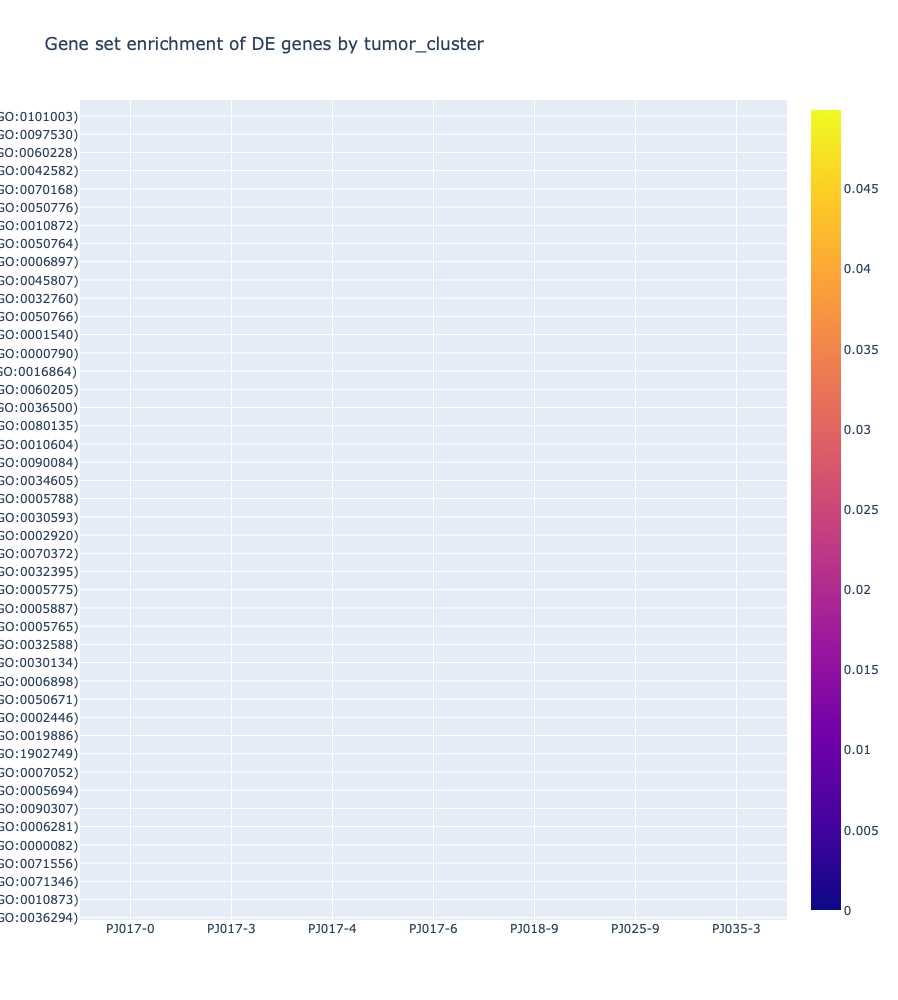

In [488]:
heatmap(results, height=1000, width=600)

# PHATE plot of cell expressions

In [496]:
all_tumor_df.loc[[tumor], biomarkers].values.shape

(3768, 76)

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:291: RuntimeWarning:

Detected zero distance between 210 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:449: RuntimeWarning:

overflow encountered in power



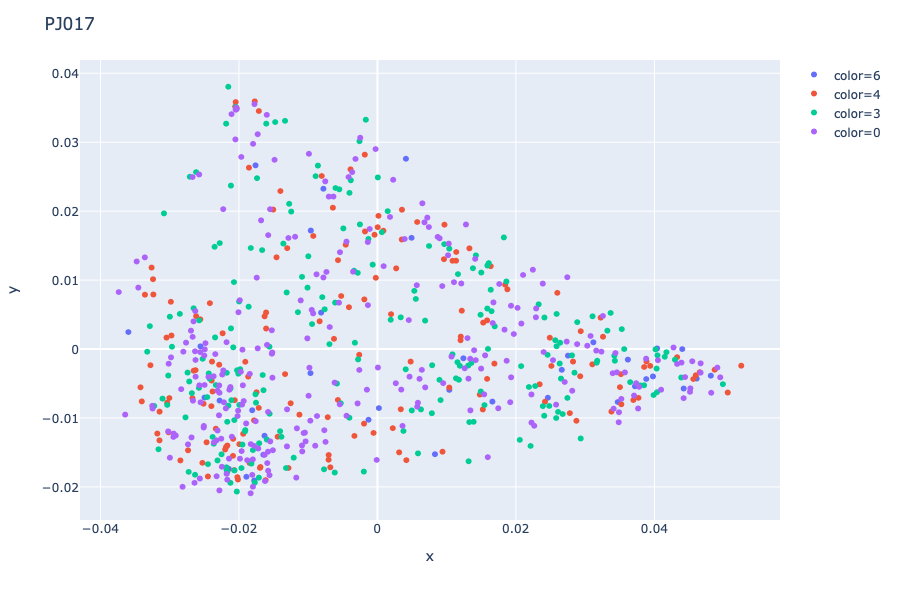

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:282: RuntimeWarning:

Detected zero distance between samples 1539 and 2042, 1539 and 2127, 2042 and 2127. Consider removing duplicates to avoid errors in downstream processing.



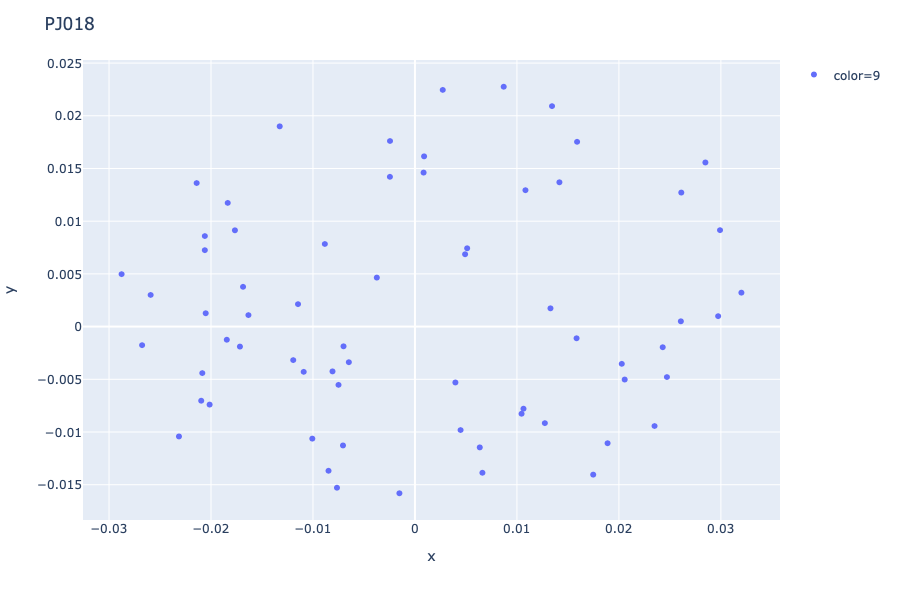

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:291: RuntimeWarning:

Detected zero distance between 554 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:449: RuntimeWarning:

overflow encountered in power



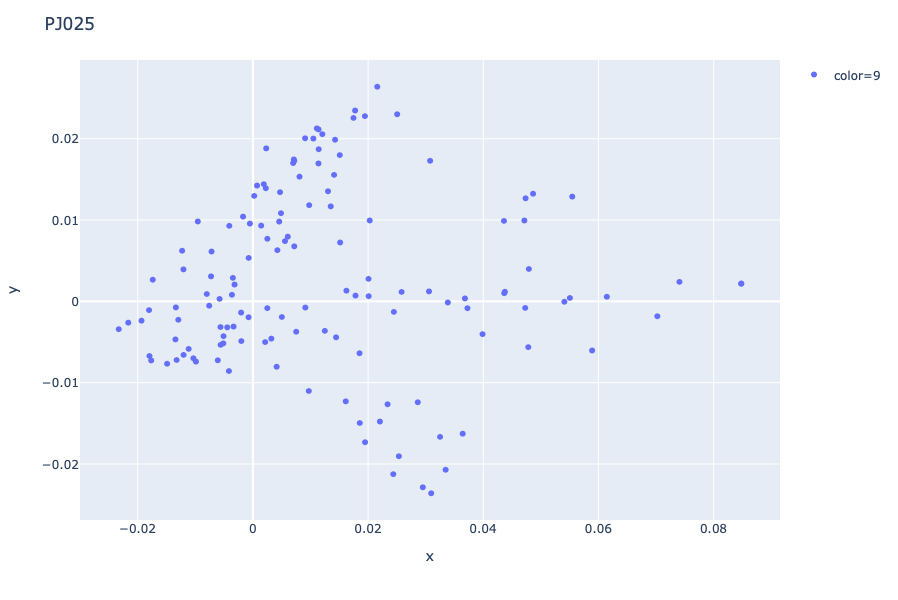

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:291: RuntimeWarning:

Detected zero distance between 2762 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.

/Users/jonny/anaconda3/lib/python3.6/site-packages/graphtools/graphs.py:449: RuntimeWarning:

overflow encountered in power



KeyboardInterrupt: 

In [493]:
tumor_cluster_with_gsea = results.T.index

for tumor in tumor_cluster_with_gsea.get_level_values(0).unique():
    clusters = tumor_cluster_with_gsea.to_frame().loc[tumor]["cluster"].values
    cells = tumor_cell_cluster.loc[tumor]
    cells_ids_belonging_to_cluster = cells[cells["cluster"].isin(clusters)].index
    if cells.shape[0] == 0: continue
    
    # Calculate PHATE on all expressions
    phate_operator = phate.PHATE(n_jobs=-2, random_state=1, verbose=False)
#     phate_operator = umap.UMAP(n_components=2, random_state=1, verbose=False)
    X_phate = phate_operator.fit_transform(all_tumor_df.loc[[tumor], biomarkers])
    assert X_phate.shape[0] == cells.shape[0]
    
    fig = px.scatter(x=X_phate[cells_ids_belonging_to_cluster.astype(int)-1, 0], 
                     y=X_phate[cells_ids_belonging_to_cluster.astype(int)-1, 1], 
                     color=cells.loc[cells_ids_belonging_to_cluster]["cluster"].tolist()
                    )
    fig.update_layout(title=tumor)
    fig.show()